In [ ]:
select 
    'OrderDetails' as table_name, 
    count(case when "order id" is null then 1 end) as missing_order_id,
    count(case when "session id" is null then 1 end) as missing_cooking_session_id,
    count(case when "order date" is null then 1 end) as missing_order_date,
    count(case when "meal type" is null then 1 end) as missing_meal_type,
    count(case when "dish name" is null then 1 end) as missing_dish_name,
    count(case when "order status" is null then 1 end) as missing_order_status,
    count(case when "amount (usd)" is null then 1 end) as missing_amount_usd,
    count(case when "time of day" is null then 1 end) as missing_time_of_day,
    count(case when "rating" is null then 1 end) as missing_rating,
    count(case when "session id" is null then 1 end) as missing_session_id
from "OrderDetails";

-- check missing values in cooking sessions table
select 
    'CookingSessions' as table_name, 
    count(case when "session id" is null then 1 end) as missing_cooking_session_id,
    count(case when "user id" is null then 1 end) as missing_user_id,
    count(case when "dish name" is null then 1 end) as missing_dish_name,
    count(case when "meal type" is null then 1 end) as missing_meal_type,
    count(case when "session start" is null then 1 end) as missing_session_start,
    count(case when "session end" is null then 1 end) as missing_session_end,
    count(case when "duration (mins)" is null then 1 end) as missing_duration_mins
from "CookingSessions";

-- check missing values in user details table
select 
    'UserDetails' as table_name, 
    count(case when "user id" is null then 1 end) as missing_user_id,
    count(case when "user name" is null then 1 end) as missing_user_name,
    count(case when age is null then 1 end) as missing_age,
    count(case when location is null then 1 end) as missing_location,
    count(case when "registration date" is null then 1 end) as missing_registration_date,
    count(case when phone is null then 1 end) as missing_phone,
    count(case when email is null then 1 end) as missing_email,
    count(case when "favorite meal" is null then 1 end) as missing_favorite_meal,
    count(case when "total orders" is null then 1 end) as missing_total_orders
from "UserDetails";

### CHECKING FOR MISSING VALUES

We have missing rating for 2 orders. But they are genuine cases as those belong to cancelled orders.



There are no missing records in Cooking Sessions



There are no missing records in UserDetails



### DATA MERGING

In [ ]:
-- joining tables
select
    c."session id" as cooking_session_id,
    c."user id" as cooking_user_id,
    c."dish name" as cooking_dish_name,
    c."meal type" as cooking_meal_type,
    c."session start",
    c."session end",
    c."duration (mins)",
    
    o."order id",
    o."session id" as order_session_id, -- renamed to avoid duplication
    o."order date",
    o."meal type" as order_meal_type,
    o."dish name" as order_dish_name,
    o."order status",
    o."amount (usd)",
    o."time of day",
    o."rating",

    u."user id" as userdetails_user_id, -- renamed to avoid duplication
    u."user name",
    u.age,
    u.location,
    u."registration date",
    u.phone,
    u.email,
    u."favorite meal",
    u."total orders"
from
    CookingSessions as c
    left join OrderDetails as o on c."session id" = o."session id"
    left join UserDetails as u on c."user id" = u."user id";

### Relationship Between Cooking Sessions and Orders

In [ ]:
with user_level_orders as (
    select 
        cooking_meal_type, 
        cooking_user_id,
        count(case when "order status" = 'Completed' then "order id" end) AS orders_placed,
        sum(case when "order status" = 'Completed' then "amount (usd)" end) AS order_amount
    from
        combined_data
    group by
        1, 2
)

select
    *
from
    user_level_orders

Checking user level order/amount placed per meal type



In [ ]:
select
    cooking_meal_type,
    sum(orders_placed) as total_orders_placed,
    avg(orders_placed) as avg_orders_placed_per_user,

    sum(order_amount) as total_amount_spent,
    avg(order_amount) as avg_amount_spent_per_user
from
    user_level_orders
group by
    1

**Breakfast**-> On average user place **1** order amount to **$ 7.8**

**Lunch**-> On average user place **0.8** order amount to **$ 9.7**

**Dinner **-> On average user place **1** order amount to **$ 15.6**



### POPULAR DISHES

In [ ]:
SELECT
    cooking_dish_name, 
    count(case when "order status" = 'Completed' then "order id" end) AS no_of_orders
FROM 
    combined_data
GROUP BY 
    1
ORDER BY 
    2 desc
limit 10;

Checking which dishes are the most popular



`**Spaghetti **`is the most popular dish having ordered `**4**` times



In [ ]:
with dish_meal_type_agg as (
    SELECT
        cooking_meal_type,
        cooking_dish_name, 
        count(case when "order status" = 'Completed' then "order id" end) AS no_of_orders
    FROM 
        combined_data
    GROUP BY 
        1, 2
)

select
    *,
    rank() over(partition by cooking_meal_type order by no_of_orders desc) as rk
from
    dish_meal_type_agg

Checking which dishes are the most popular at each meal type



In [ ]:
select
    cooking_meal_type,
    cooking_dish_name
from
    dish_meal_type_rk
where
    rk = 1

People prefer  `Pancakes` at **Breakfast**, `Caesar Salad` at **Lunch **and `Spaghetti` at **Dinner**



### Demographic Analysis

Checking which dishes are the most popular at each location



In [ ]:
with dish_location_agg as (
    SELECT
        location,
        cooking_dish_name, 
        count(case when "order status" = 'Completed' then "order id" end) AS no_of_orders
    FROM 
        combined_data
    GROUP BY 
        1, 2
)

select
    *,
    rank() over(partition by location order by no_of_orders desc) as rk
from
    dish_location_agg

In [ ]:
select
    location,
    cooking_dish_name
from
    dish_location_rank
where
    rk = 1

- Miami -> People prefer ,`Veggie Burger`
- Seattle -> People prefer ,`Grilled Chicken`, and,` Caesar Salad`, equally
- Boston -> People prefer ,`Spaghetti`
- New York -> People prefer,` Spaghetti, Pancakes and Grilled Chicken`, equally
- Austin -> People prefer ,`Grilled Chicken`
- Chicago -> People prefer ,`Pancakes`
- Los Angeles -> People prefer ,`Caesar Salad, Spaghetti, Oatmeal`, equally
- San Francisco -> People prefer ,`Caesar Salad`, and ,`Spaghetti`, equally



Checking dish preferences of different age group



In [ ]:
with age_group_dish_orders as (
SELECT
    case 
        when age between 20 and 25 then '20-25'
        when age between 26 and 30 then '26-30'
        when age between 31 and 40 then '31-40'
        when age between 41 and 45 then '41-45'
        when age between 46 and 50 then '46-50'
    end as age_group,
    cooking_dish_name, 
    count(case when "order status" = 'Completed' then "order id" end) AS no_of_orders
FROM 
    combined_data
GROUP BY 
    1, 2
)

select
    *,
    rank() over(partition by age_group order by no_of_orders desc) as rk
from 
    age_group_dish_orders


In [ ]:
select
    age_group,
    cooking_dish_name
from
    age_group_dish_orders_rk
where
    rk = 1

- 20-25 age group prefers ,`Grilled Chicken`
- 26-30 age group prefers ,`Spaghetti, Caesar Salad and Grilled Chicken`
- 31-40 age group prefers ,`Spaghetti`
- 41-45 age group prefers ,`Pancakes`



Checking orders trends over each day



In [ ]:
SELECT
    "order date",
    count(case when "order status" = 'Completed' then "order id" end) AS no_of_orders
FROM 
    combined_data
GROUP BY 
    1

### Repeat Customers

In [ ]:
SELECT 
    cooking_user_id, 
    count("order id") AS no_of_orders
FROM 
    combined_data
GROUP BY 
    1


In [ ]:
select
    no_of_orders,
    cooking_user_id,
    u."user name"

from
    user_order_frequency a
    left join UserDetails as u on a."cooking_user_id" = u."user id"

**Alice Johnson,** **Bob Smith**, **Charlie Lee** has ordered the most - each `**3**` times.



### Order to Cooking Session Ratio

In [ ]:
SELECT AVG(OrderCount) AS AvgOrdersPerSession
FROM (
    SELECT "Session ID", COUNT("Order ID") AS OrderCount
    FROM "OrderDetails"
    GROUP BY "Session ID"
) AS SubQuery;


On average `**one**` order is placed each session



### Python

In [ ]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cookingsesession=pd.read_csv("Assignment.xlsx - CookingSessions.csv.csv")
orderdetails=pd.read_csv("Assignment.xlsx - OrderDetails.csv.csv")
userdetails=pd.read_csv("Assignment.xlsx - UserDetails.csv.csv")


In [ ]:
# Checking missing values in Cooking Session Table

cookingsesession.isnull().sum()

Session ID         0
User ID            0
Dish Name          0
Meal Type          0
Session Start      0
Session End        0
Duration (mins)    0
Session Rating     0
dtype: int64

In [ ]:
# Checking missing values in Order Details Table

orderdetails.isnull().sum()

Order ID        0
User ID         0
Order Date      0
Meal Type       0
Dish Name       0
Order Status    0
Amount (USD)    0
Time of Day     0
Rating          2
Session ID      0
dtype: int64

In [ ]:
# Checking missing values in User Details Table

userdetails.isnull().sum()

User ID              0
User Name            0
Age                  0
Location             0
Registration Date    0
Phone                0
Email                0
Favorite Meal        0
Total Orders         0
dtype: int64

In [ ]:
# Merge the Datasets

merged_data = pd.merge(userdetails, cookingsesession, on='User ID')
display(merged_data)


,User ID,User Name,Age,Location,Registration Date,Phone,Email,Favorite Meal,Total Orders,Session ID,Dish Name,Meal Type,Session Start,Session End,Duration (mins),Session Rating
0,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12,S001,Spaghetti,Dinner,12/1/2024 19:00:00,12/1/2024 19:30:00,30,4.5
1,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12,S004,Pancakes,Breakfast,12/2/2024 7:30:00,12/2/2024 8:00:00,30,4.2
2,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12,S009,Grilled Chicken,Dinner,12/5/2024 19:00:00,12/5/2024 19:40:00,40,4.9
3,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8,S002,Caesar Salad,Lunch,12/1/2024 12:00:00,12/1/2024 12:20:00,20,4.0
4,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8,S006,Spaghetti,Dinner,12/3/2024 18:30:00,12/3/2024 19:00:00,30,4.3
5,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8,S010,Oatmeal,Breakfast,12/5/2024 7:00:00,12/5/2024 7:10:00,10,4.1
6,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15,S003,Grilled Chicken,Dinner,12/2/2024 19:30:00,12/2/2024 20:10:00,40,4.8
7,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15,S008,Veggie Burger,Lunch,12/4/2024 13:30:00,12/4/2024 13:50:00,20,4.4
8,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15,S011,Pancakes,Breakfast,12/6/2024 8:00:00,12/6/2024 8:30:00,30,4.6
9,U004,David Brown,27,San Francisco,2023-04-05,444-333-2222,david@email.com,Dinner,10,S005,Caesar Salad,Lunch,12/3/2024 13:00:00,12/3/2024 13:15:00,15,4.7


In [ ]:
# Merging the new table merged_data with orderdetails table

final_merge=pd.merge(merged_data, orderdetails, on="Session ID")
display(final_merge)

,User ID_x,User Name,Age,Location,Registration Date,Phone,Email,Favorite Meal,Total Orders,Session ID,...,Session Rating,Order ID,User ID_y,Order Date,Meal Type_y,Dish Name_y,Order Status,Amount (USD),Time of Day,Rating
0,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12,S001,...,4.5,1001,U001,01-12-2024,Dinner,Spaghetti,Completed,15.0,Night,5.0
1,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12,S004,...,4.2,1004,U001,02-12-2024,Breakfast,Pancakes,Completed,8.0,Morning,4.0
2,U001,Alice Johnson,28,New York,2023-01-15,123-456-7890,alice@email.com,Dinner,12,S009,...,4.9,1009,U001,05-12-2024,Dinner,Grilled Chicken,Completed,12.0,Night,5.0
3,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8,S002,...,4.0,1002,U002,01-12-2024,Lunch,Caesar Salad,Completed,10.0,Day,4.0
4,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8,S006,...,4.3,1006,U002,03-12-2024,Dinner,Spaghetti,Completed,14.0,Night,4.0
5,U002,Bob Smith,35,Los Angeles,2023-02-20,987-654-3210,bob@email.com,Lunch,8,S010,...,4.1,1010,U002,05-12-2024,Breakfast,Oatmeal,Completed,7.0,Morning,4.0
6,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15,S003,...,4.8,1003,U003,02-12-2024,Dinner,Grilled Chicken,Canceled,12.5,Night,NaN
7,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15,S008,...,4.4,1008,U003,04-12-2024,Lunch,Veggie Burger,Canceled,11.0,Day,NaN
8,U003,Charlie Lee,42,Chicago,2023-03-10,555-123-4567,charlie@email.com,Breakfast,15,S011,...,4.6,1011,U003,06-12-2024,Breakfast,Pancakes,Completed,8.5,Morning,4.0
9,U004,David Brown,27,San Francisco,2023-04-05,444-333-2222,david@email.com,Dinner,10,S005,...,4.7,1005,U004,03-12-2024,Lunch,Caesar Salad,Completed,9.0,Day,4.0


In [ ]:
# The Relationship between cooking sessions and orders

cooking_order_count = final_merge.groupby('Session ID')['Order ID'].count()
cooking_order_count.rename({"Order ID": "OrderCount"}, inplace=True)



display(cooking_order_count)


Session ID
S001    1
S002    1
S003    1
S004    1
S005    1
S006    1
S007    1
S008    1
S009    1
S010    1
S011    1
S012    1
S013    1
S014    1
S015    1
S016    1
Name: Order ID, dtype: int64

In [ ]:
# Popular Dishes

popular_dishes = final_merge["Dish Name_y"].value_counts()
display(popular_dishes)


Spaghetti          4
Grilled Chicken    4
Caesar Salad       3
Pancakes           2
Veggie Burger      2
Oatmeal            1
Name: Dish Name_y, dtype: int64

In [ ]:
# Order By Age 

age=final_merge.groupby("Age")['Order ID'].value_counts()
display(age)

Age  Order ID
25   1014        1
27   1005        1
     1012        1
28   1001        1
     1004        1
     1009        1
30   1007        1
     1013        1
31   1016        1
35   1002        1
     1006        1
     1010        1
38   1015        1
42   1003        1
     1008        1
     1011        1
Name: Order ID, dtype: int64

In [ ]:
# Locations

location=final_merge["Location"].value_counts()
display(location)

New York         3
Los Angeles      3
Chicago          3
San Francisco    2
Seattle          2
Austin           1
Boston           1
Miami            1
Name: Location, dtype: int64

In [ ]:
# Peak Timing
timing=final_merge.groupby("User ID_y")["Time of Day"].value_counts()
display(timing)

User ID_y  Time of Day
U001       Night          2
           Morning        1
U002       Day            1
           Morning        1
           Night          1
U003       Day            1
           Morning        1
           Night          1
U004       Day            1
           Night          1
U005       Day            1
           Night          1
U006       Night          1
U007       Night          1
U008       Day            1
Name: Time of Day, dtype: int64

In [ ]:
order_count=final_merge["Order ID"].value_counts()
display(order_count)

1001    1
1004    1
1009    1
1002    1
1006    1
1010    1
1003    1
1008    1
1011    1
1005    1
1012    1
1007    1
1013    1
1014    1
1015    1
1016    1
Name: Order ID, dtype: int64

Text(0.5, 1.0, 'Most Popular Dishes')

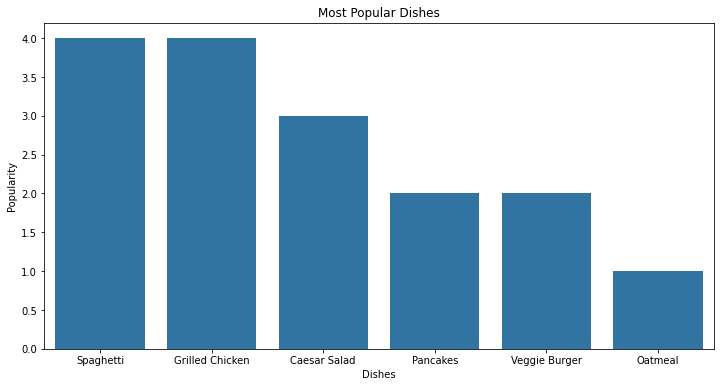

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=popular_dishes.index, y=popular_dishes.values)
plt.xlabel('Dishes')
plt.ylabel('Popularity')
plt.title('Most Popular Dishes')


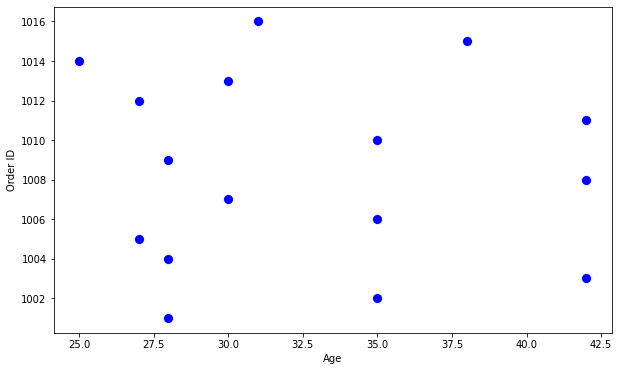

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_merge, x="Age", y="Order ID", s=100, color="blue", marker="o")
plt.show()

Text(0.5, 1.0, 'Most Order Location')

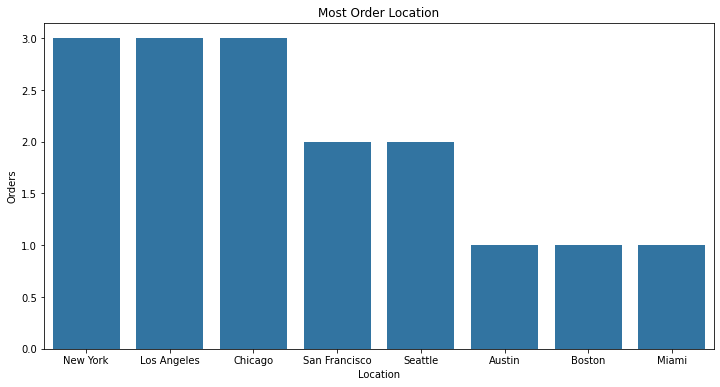

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=location.index, y=location.values)
plt.xlabel('Location')
plt.ylabel('Orders')
plt.title('Most Order Location')

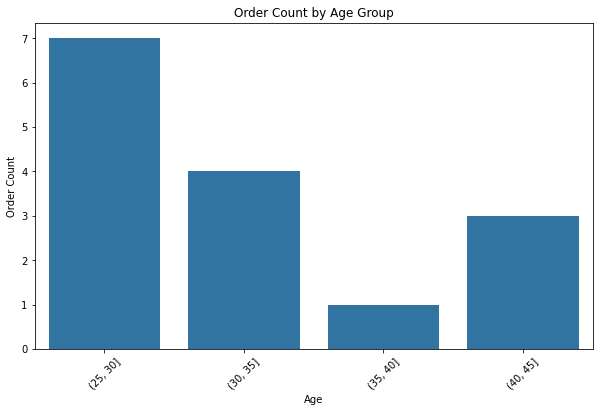

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by age and count the number of orders
age_order_count = final_merge.copy()
age_order_count["Age Group"] = pd.cut(
    age_order_count["Age"], bins=range(25, age_order_count["Age"].max() + 5, 5)
)
age_order_count = (
    age_order_count.groupby("Age Group").size().reset_index(name="Order Count")
)

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x="Age Group", y="Order Count", data=age_order_count)
plt.title("Order Count by Age Group")
plt.xlabel("Age")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.show()